# 1 Distributed Gradient Descent in Python: A Tutorial

### **Introduction**

Gradient descent is a widely used optimization algorithm for training machine learning models. In this tutorial, we will learn how to implement a **distributed gradient descent (GD) algorithm** for training a simple **linear regression model**. The goal of distributed gradient descent is to split the work of calculating gradients across multiple processes or machines to accelerate model training.

For this tutorial, we will use Python’s multiprocessing library to simulate distributed gradient descent on a single machine (i.e., a multi-core CPU). This approach can also be extended to more complex distributed systems, but for simplicity, we will simulate the process locally.


## **Step 1: Setup and Sample Data**
Let's start by creating a synthetic dataset that we will use to train a simple linear regression
model. <br>Our model will have the equation:
$$y = w \cdot x + b$$

Where:
- $w$ is the weight (slope)
- $b$ is the bias (intercept)

We'll generate synthetic data with some noise to make it more realistic.

In [1]:
#import necessary module
import numpy as np
import matplotlib.pyplot as plt


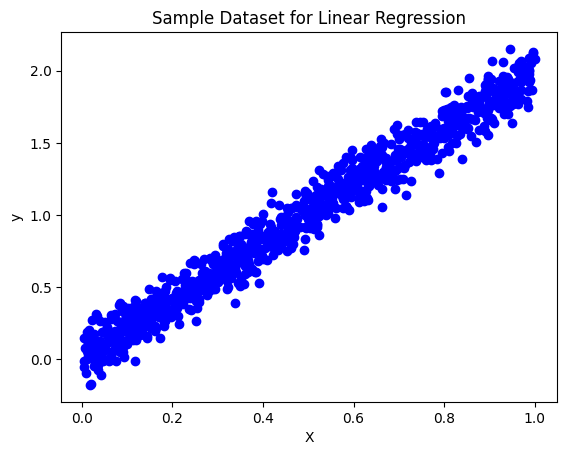

In [2]:
# Create synthetic data
np.random.seed(42)
X = np.random.rand(1000, 1)  # 1000 samples, 1 feature
y = 2 * X + np.random.randn(1000, 1) * 0.1  # y = 2*x + noise

# Visualize the data
plt.scatter(X, y, c='blue', label='Data points')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Sample Dataset for Linear Regression')
plt.show()

## **Step 2: Gradient Descent Function**

We now implement the gradient descent algorithm. The goal is to minimize the Mean Squared Error (MSE) between the predicted values and the actual values. For linear regression, the loss function (MSE) is:

$$MSE = \frac{1}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i)^2$$

Where:
- $m$ is the number of samples  
- $\hat{y}_i$ is the predicted value  

The gradient of the MSE with respect to w and $b$ is:

$$\frac{\partial MSE}{\partial w} = \frac{2}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i) \cdot x_i$$
$$\frac{\partial MSE}{\partial b} = \frac{2}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i)$$

The updates for the parameters are:
$$w = w - \eta \cdot \frac{\partial MSE}{\partial w}$$
$$b = b - \eta \cdot \frac{\partial MSE}{\partial b}$$

Where $\eta$ is the learning rate.


In [3]:
def compute_mse(X, y, w, b):
    m = len(y)
    predictions = X.dot(w) + b
    mse = (1/m) * np.sum((predictions - y) ** 2)
    return mse

def compute_gradients(X, y, w, b):
    m = len(y)
    predictions = X.dot(w) + b
    dw = (2/m) * X.T.dot(predictions - y)
    db = (2/m) * np.sum(predictions - y)
    return dw, db

## **Step 3: Simulate Distributed Gradient Descent**

We will now implement the core of distributed gradient descent using Python’s multiprocessing library. The dataset will be divided into smaller chunks, and each process will compute the gradients on its portion of the data. The results will then be aggregated to update the parameters.

Here is the implementation:

In [4]:
import multiprocessing as mp

In [5]:
# Function to be run by each process
def gradient_descent_process(rank, X_split, y_split, w, b, result_queue):
    dw, db = compute_gradients(X_split, y_split, w, b) # Compute gradients on local data
    result_queue.put((dw, db)) # Place gradients in result queue

# Function to run distributed gradient descent
def distributed_gradient_descent(X, y, learning_rate=0.01, epochs=100, num_processes=4):
    # Split the data across different processes
    data_split = np.array_split(X, num_processes)
    target_split = np.array_split(y, num_processes)

    # Initialize parameters (weights and bias)
    w = np.zeros((X.shape[1], 1))  # Initialize weight to zero
    b = np.zeros((1, 1))  # Initialize bias to zero

    # Queue for collecting results from processes
    result_queue = mp.Queue()

    # Run gradient descent
    for epoch in range(epochs):
        processes = []

        # Start multiple processes for gradient computation
        for rank in range(num_processes):
            p = mp.Process(target=gradient_descent_process, args=(rank, data_split[rank], target_split[rank], w, b, result_queue))
            processes.append(p)
            p.start()

        # Collect results from all processes
        dw_total = np.zeros_like(w)
        db_total = np.zeros_like(b)
        for p in processes:
            p.join()  # Wait for all processes to finish
        while not result_queue.empty():
            dw, db = result_queue.get()
            dw_total += dw
            db_total += db

        # Update weights and bias
        w -= learning_rate * dw_total
        b -= learning_rate * db_total

        # Print the progress
        if epoch % 10 == 0:
            mse = compute_mse(X, y, w, b)
            print(f"Epoch {epoch}: MSE = {mse}")

    return w, b

## **Step 4: Running the Code**

Now, let’s run the distributed gradient descent algorithm and observe the results.

In [6]:
w_final, b_final = distributed_gradient_descent(X, y)
# Print the final parameters
print("Final weights:", w_final)
print("Final bias:", b_final)

Epoch 0: MSE = 1.1121297504369327
Epoch 10: MSE = 0.3011721684514258
Epoch 20: MSE = 0.18753188970039486
Epoch 30: MSE = 0.1591880313386306
Epoch 40: MSE = 0.14258754146228378
Epoch 50: MSE = 0.1287554255326677
Epoch 60: MSE = 0.11647543934951882
Epoch 70: MSE = 0.10547602577929374
Epoch 80: MSE = 0.09561184787576438
Epoch 90: MSE = 0.08676432299896585
Final weights: [[1.0861484]]
Final bias: [[0.48990946]]


### **Explanation of the Code:**

**1. Data Splitting:**
    <br>The dataset X and y is divided into num_processes parts, where each part is handled by a different process.

**2. Gradient Calculation:**
    <br>Each process computes the gradients based on its subset of data.

**3. Result Collection:**
    <br>The gradients are collected into a queue, which is then processed by the main thread to sum the gradients.

**4. Parameter Update:**
    <br>The weights and bias are updated using the total gradients computed across all processes.

**5. Final Output:**
    <br>After all epochs, the final learned parameters (weights and bias) are printed.